In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy.random as r

# Her i starten indlæses bare data og korrigeres for k_acc, som vi har gjort tidligere. Led efter næste markdown, hvor der står, at der er ændringer

Text(0.5, 1.0, 'Gennemsnitlig temperaturafvigelse gennem den Holocæne periode')

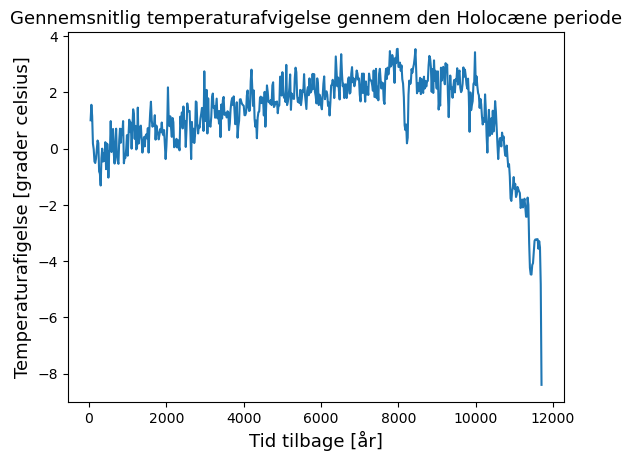

In [2]:
rådata_holocæn = pd.read_excel('Temperaturdata_alene.xlsx', header = 29)
rådata_holocæn = rådata_holocæn.to_numpy()
år20_rå = rådata_holocæn[:,0]
temp20_rå = rådata_holocæn[:,1]

plt.plot(år20_rå,temp20_rå)

plt.xlabel('Tid tilbage [år]', fontsize = 13)
plt.ylabel('Temperaturafigelse [grader celsius]', fontsize = 13)
plt.title("Gennemsnitlig temperaturafvigelse gennem den Holocæne periode", fontsize = 13)

In [3]:
rådata = pd.read_excel('Ægte_DailyMinMax_Ilullisat_Cor-2.xlsx')
print(rådata)
data = rådata.to_numpy()
år_rå, temp_rå = data[:,0], data[:,1]

KeyboardInterrupt: 

Interpolering af DMI-data

216227
216227 216227


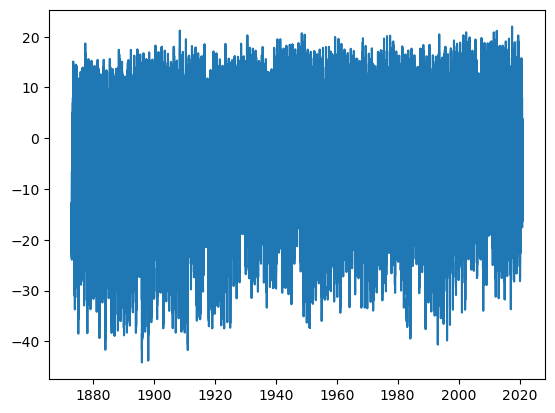

In [ ]:
def interpolation_år():
    interpol_år = []
    år = []
    temp = []
    for i in range(1, len(år_rå)):      # Finder mellempunkter for årsarrayet
        punkt = (år_rå[i] + år_rå[i-1])/2
        interpol_år.append(punkt)
    
    for i in range(len(interpol_år)):   # Laver liste med både DMI-årstal og mellempunkter
        år.append(år_rå[i])
        år.append(interpol_år[i])
    #print(interpol_år)
    år.append(år_rå[-1])   # Tilføjer det sidste rå datapunkt manuelt, da der et ét råt datapunkt mere end mellempunkterne.
    print(len(år))
    return år
    
år_DMI_inter = interpolation_år()      # Interpolerer temperaturdataen

år_DMI_inter = np.array(år_DMI_inter)

temp_DMI_inter = np.interp(år_DMI_inter, år_rå, temp_rå)

plt.plot(år_DMI_inter, temp_DMI_inter)

print(len(år_DMI_inter), len(temp_DMI_inter))

In [31]:
råsatellit = pd.read_csv('greenland_mass_200204_202311.txt', delimiter = '\s+', header = None, skiprows = lambda x: x < 31)
satellit = råsatellit.to_numpy()
år_sat, dmasse_sat = satellit[:, 0], satellit[:, 1]
densitet_is = 917
dvol_sat = 10**12 * dmasse_sat/densitet_is   # Vi omregner massetilvækst til volumentilvækst
V_sat_err = 10**12 * abs(1/densitet_is * satellit[:,2])

In [32]:
top = max(år_sat)   
bund = min(år_sat)

print(top)
print(bund)

# Slicing af DMI-data

temp_DMI = temp_DMI_inter[(år_DMI_inter <= top) & (år_DMI_inter >= bund)] # Nyt temperatur-array, som kun indeholder temperaturer for samme årrække som satellitdata
år_DMI = år_DMI_inter[(år_DMI_inter <= top) & (år_DMI_inter >= bund)] # Sørger for, at vi også har et årstals-array med de tilsvarende indgange (samme maske)

# Slicing af GRACE-data
topDMI = max(år_DMI)
dmasse_sat = dmasse_sat[år_sat <= topDMI]
dvol_sat = dvol_sat[år_sat <= topDMI]
V_sat_err = V_sat_err[år_sat <= topDMI]
år_sat = år_sat[år_sat <= topDMI]

2023.87
2002.29


In [82]:
råNGRIP = pd.read_excel('rådata NGRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 58, usecols = [0,1,2,3,4,5,6,7,8])
råGRIP = pd.read_excel('GRIP_acc_Vinther_etal_2009_GICC05_16Sep2010.xlsx', header = 54, usecols = [0,1,2,3,4,5,6,7])

NGRIP, GRIP = råNGRIP.to_numpy(), råGRIP.to_numpy()
NGRIPakk0, GRIPakk0 = NGRIP[:, 6], GRIP[:, 5]
NGRIPår0, GRIPår0 = NGRIP[:, 1], GRIP[:, 1]
NGRIP_delevation, GRIP_delevation = NGRIP[:, 8], GRIP[:, 7]

In [34]:
akk_list = (NGRIPakk0[1:21] + GRIPakk0[1:21])/2   # Tager ikke første punkt med grunden manglende nedbørsdata
akk_gns = np.mean(akk_list)
print('gns akkumulation = ', akk_gns)

gns akkumulation =  0.2034321448890318


In [35]:
def optimering_akk(M_akk_tabel):

    dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit


    V_start = 2.99 * 10**15   # startvolumen af iskappe
    H = 3 * 10**3       # Starthøjde af iskappe
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    V_sat = dvol_sat + V_0 - dvol_sat[0]
    
    R = (3/16*V/H)**(1/2)    # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år

    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden
    k_acc_test = 1   # Denne tuningskonstant kommer fra vores undervurdering af nedbøren. Den kan vi også tune på, hvis nødvendigt. 
    k_melt = 1

    #Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []


    for i in range(len(år_DMI)):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
       
        V_acc = k_acc_test * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
       
        if temp_DMI[i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[i] - T_f) * ((T_f - temp_DMI[i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V += V_acc - V_melt

        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)

   
    V_sum = np.sum(V_acc_list)/(år_DMI[-1] - år_DMI[0])
    V_akk_tabel = (M_akk_tabel)/(densitet_is) #m^3

    k_acc = V_akk_tabel/V_sum
    
    return k_acc

In [36]:
M_akk_mean = 642 * 10**12

optimering_akk(M_akk_mean)

2.30089779452381

In [37]:
M_akk_mean = 642 * 10**12    #kg
M_akk_std = 59 * 10**12    #kg

M_akk_list = r.normal(M_akk_mean, M_akk_std, 100)

k_acc_værdier = []

for x in M_akk_list:
    k_acc = optimering_akk(x)

    k_acc_værdier.append(k_acc)

print(k_acc_værdier)

tester = [M_akk_mean - M_akk_std, M_akk_mean, M_akk_std + M_akk_mean]
print(tester)

[2.1651706923307295, 2.4215028063661723, 2.608853825506833, 1.994000441212601, 2.543211703962658, 2.1932672633014496, 2.149272624548628, 2.3427118424771436, 2.66332764998094, 2.332840153239726, 2.031461141207588, 2.6473491768536705, 2.2747662482929725, 2.1471719021978295, 2.422656548038682, 2.1276767316832492, 1.7594978196280249, 2.260378167479101, 2.403484032706173, 2.2821275446861695, 2.4188454911854604, 2.0931033891695154, 2.067572793389398, 2.3969436489050118, 2.016624757863491, 2.3999336341081654, 2.1782092988202537, 2.422829203715156, 2.1534371044470415, 1.959902979943023, 2.3804573910369595, 2.395183417377668, 2.2049390991926807, 2.1894398557399253, 2.522927245796553, 2.30667966529758, 2.3316779528829876, 2.1213218238596214, 2.6709564565340207, 2.3880828282269415, 1.9137305095270902, 1.9510465783151043, 2.0056607371120103, 2.6268679165017095, 2.450222673264638, 2.400278038857973, 2.3453658909357413, 2.4414223017541152, 2.2490769916515307, 2.2769053364388, 2.575180158167973, 2.40

# __HERFRA NYT__

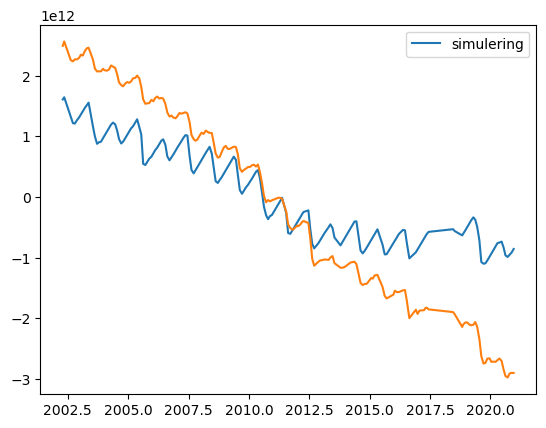

In [38]:
V_start = 2.99 * 10**15   # startvolumen af iskappe
dvol_sat_korr = dvol_sat - np.mean(dvol_sat) # volumenændringer for GRACE korrigeres, så det har nulpunkt i sit gennemsnit
dvol_sat_err_korr = np.sqrt(V_sat_err**2 + (np.std(dvol_sat)/np.sqrt(len(dvol_sat)))**2)


def simulering(år_sat, k_melt):
    
    # De globale konstanter defineres
    V = V_start  # startvolumen af iskappe
    V_0 = V_start 
    H = 3 * 10**3       # Starthøjde af iskappe
    R = (3/16*V/H)**(1/2)     # Startradius af iskappe
    T_f = 0        
    alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
    k = H/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
    dt = 1/(365.25 * 4)  # Tidsskridt (her 1/4 døgn) - omregnet til år
    
    acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden

    
    # Der oprettes tomme lister til resultatet af simuleringen
    V_list = []
    V_melt_list = []
    V_acc_list = []
    
    
    for i in range(1, len(år_DMI) + 1):
        R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
        
        V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
        
        if temp_DMI[-i] - T_f <= 0:
            V_melt = 0
        elif temp_DMI[-i] - T_f > 0:
            V_melt = k_melt * 8/3 * R * (temp_DMI[-i] - T_f) * ((T_f - temp_DMI[-i])/(alfa * k))**2 * dt  # ganger tidsskridt og M på
        V +=  - V_acc + V_melt
        
        V_list.append(V)
        V_melt_list.append(V_melt)
        V_acc_list.append(V_acc)
    
    V_list.reverse()

    dvol_sim = V_list - np.mean(V_list)

    dvol_sim_fit = np.interp(år_sat, år_DMI, dvol_sim)

    return dvol_sim_fit 


# Nedenstående er bare et tjek af den nye funktion, som er lidt anderledes end de gamle
test = simulering(år_sat, 6.7)

#plt.plot(år, V_list)
plt.plot(år_sat, test, label = 'simulering')
plt.plot(år_sat, dvol_sat_korr)
plt.legend()


## Curve_fit

In [39]:
k_melt_list = []
k_melt_err_list = []

for x in k_acc_værdier:
    k_acc = x
    par, cov = curve_fit(simulering, år_sat, dvol_sat_korr, p0 = 1, sigma = dvol_sat_err_korr, absolute_sigma= True)
    k_melt_list.append(par[0])
    k_melt_err_list.append(np.sqrt(cov[0,0]))

In [40]:
print(len(k_melt_list))
print(k_melt_err_list)

100
[0.013303353723537296, 0.013305723159935653, 0.013306172390572997, 0.013305703738012032, 0.013305183345063509, 0.013305512038820353, 0.013305454730008643, 0.013306882542151224, 0.01330908224696714, 0.013307079797784274, 0.013301584524142653, 0.013308049311217037, 0.013304795459118952, 0.013303799209797284, 0.013305899251635578, 0.01330333040490457, 0.01330306445146381, 0.013305262268560452, 0.013306199924799577, 0.013305119741815493, 0.013304335568946134, 0.013303208841094363, 0.013305380657529647, 0.01330783801033206, 0.0133030759717836, 0.013304275856631863, 0.01330422315013258, 0.013306487713859312, 0.013306209737339453, 0.01330070517684322, 0.013305255811346763, 0.013306026377644027, 0.013305773634698726, 0.013304928572973123, 0.013305015574796858, 0.013304891456304192, 0.013305744064020346, 0.013303350321747688, 0.01330701700651286, 0.013306280152687353, 0.013301581412097077, 0.013302895070935926, 0.013306111396985601, 0.013307691858124731, 0.013303460598841212, 0.013306339794

# __Lange kørsler__

Forskellen er 5.5608806093626635


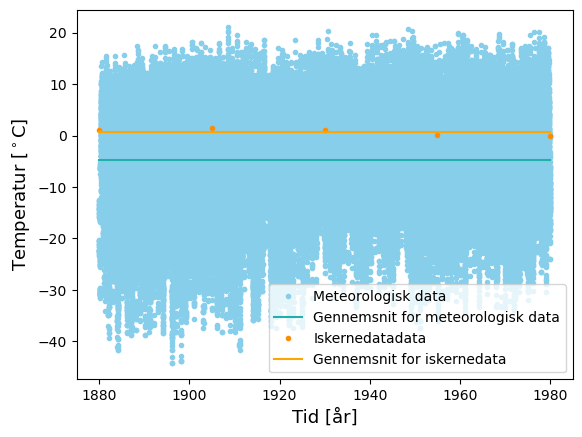

In [41]:
gns1 = np.average(temp20_rå[0:5])

top = 1980
bund = 1880
temp_X = temp_rå[(år_rå >= bund)&(år_rå < top)]

gns2 = np.average(temp_X)

forskel = np.absolute(gns1 - gns2)

plt.plot(np.linspace(1880,1980,len(temp_X)),temp_X, '.', c = 'skyblue', label = 'Meteorologisk data')
plt.plot(np.linspace(1880,1980,100), np.linspace(gns2,gns2,100), c = 'lightseagreen', label = 'Gennemsnit for meteorologisk data')

plt.plot(np.linspace(1880,1980,5),temp20_rå[0:5], '.', c = 'darkorange', label = 'Iskernedatadata')
plt.plot(np.linspace(1880,1980,100), np.linspace(gns1,gns1,100), c = 'orange', label = 'Gennemsnit for iskernedata')

plt.legend()
plt.xlabel('Tid [år]', fontsize = 13)
plt.ylabel(r'Temperatur [$^\circ$C]', fontsize = 13)

print("Forskellen er", forskel)

## Simulering af iskappevolumensudvikling gennem den sidste varmeperiode

### Udvælger 20 år (år 1955-1975) og bruger deres årstidscyklus på iskernedata

[0.000000e+00 7.000000e-04 1.400000e-03 ... 1.999795e+01 1.999860e+01
 1.999930e+01]
0.0
[0.000000e+00 7.000000e-04 1.400000e-03 ... 1.999795e+01 1.999860e+01
 1.999930e+01]


Text(0, 0.5, 'Temperaturafvigelse [$^\\circ$C]')

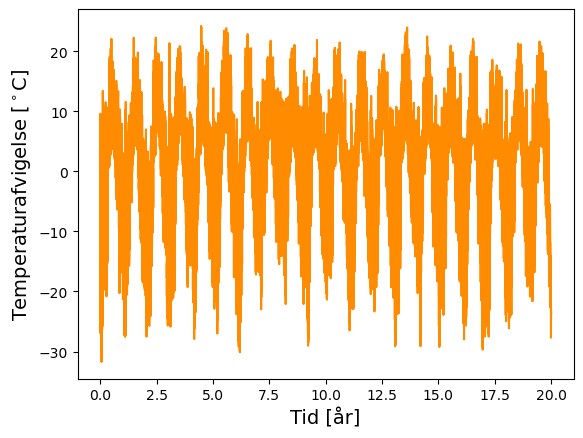

In [42]:
top = 1975
bund = 1955
maske = (år_DMI_inter >= bund) & (år_DMI_inter < top)

år_X = år_DMI_inter[maske]
år_X = år_X - år_X[0]
print(år_X)
print(min(år_X))
temp_X = temp_DMI_inter[maske]
temp_X_afv = temp_X-np.average(temp_X)

print(år_X)
plt.plot(år_X,temp_X_afv, c = 'darkorange')
plt.xlabel('Tid [år]', fontsize = 14)
plt.ylabel(r'Temperaturafvigelse [$^\circ$C]', fontsize = 14)

## Lægger årstidscyklus ind over iskernedata

In [43]:
temp_array = np.array([])
år_array = np.array([])

for i, j in np.nditer([temp20_rå, år20_rå]):
    temp_c = i + temp_X - forskel #kysttemperatur
    år_c = 2000 - j + 20 + år_X

    temp_array = np.append(temp_array, temp_c)
    år_array = np.append(år_array, år_c)

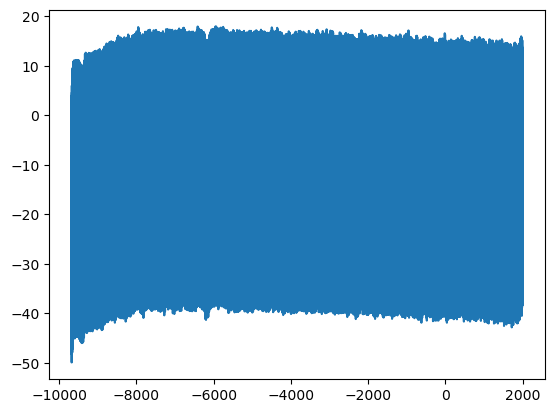

In [44]:
plt.plot(år_array, temp_array)

(0.0, 25.0)

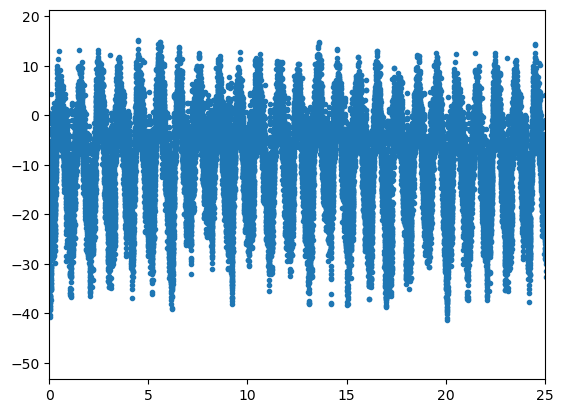

In [45]:
plt.plot(år_array, temp_array, '.')
plt.xlim(0,25)

[0.00015548 0.00015548 0.00015548 ... 0.00011565 0.00011565 0.00011565]
[1.55480686e-04 1.35583065e-04 1.20605243e-04 ... 1.13367708e-04
 6.46011486e-05 1.15647144e-04]


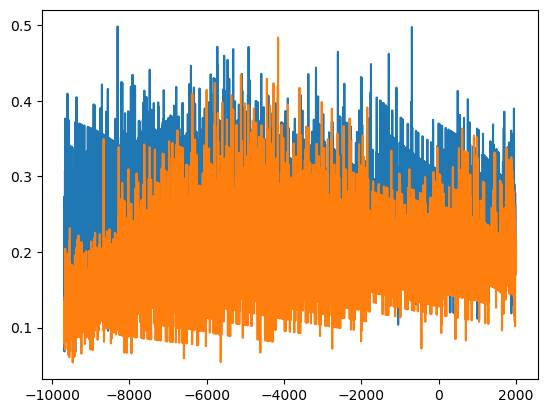

In [46]:
GRIP_age = GRIPår0[9:-24]
NGRIP_age = NGRIPår0[16:-24]
GRIP_acc_rate = GRIPakk0[9:-24]
NGRIP_acc_rate = NGRIPakk0[16:-24]

plt.plot(GRIP_age, GRIP_acc_rate)
plt.plot(NGRIP_age, NGRIP_acc_rate)


gns_acc_rate1 = (GRIP_acc_rate + NGRIP_acc_rate)/2 #m is/år fra år 1980
gns_acc_rate = np.repeat(gns_acc_rate1, 365.25*4)*1/(365.25*4)

print(gns_acc_rate)
print(gns_acc_rate1/(365.25*4))

# Simulering

In [73]:
def langtidskørsel(k_acc, k_melt):    
    V = 2.99 * 10**15        #m^3
    H = 3 * 10**3            #m
    R = (3/16*V/H)**(1/2)          #m
    T_f = 0                  #grader
    alfa = - 9.8 * 10**(-3)  #temperaturændring pr. højdeforøgelse (deg C/m)
    k = H/np.sqrt(R)         #formfaktor. Vi antager, at iskappens form ikke ændrer sig
    dt = 1/(4*365.25)        #tidsskridt i år

    #k_melt = 8.5 * 5 * 2 * 10**(-1)  #Smeltekonstant    

    V_list = []
    V_melt_list = []         #For overbliks skyld
    acc_list = []
    R_list = []
    år_list = []

    N = 17000000
    tæller = 0

    for i, j in np.nditer([temp_array[0:N], gns_acc_rate[0:N]]):
    
        R = (3/16 * V/k)**(2/5)  #Jeppes formel. Undersøges senere
        V_acc = k_acc * (j * 8 * R**2)*dt  #Volumen tilført pr tidsskridt.

        if i - T_f < 0:
            V_melt = 0

        elif i == 0:
            V_melt = 0

        elif i - T_f > 0:
            V_melt = dt*k_melt * 8/3 * R * (i - T_f) * ((T_f - i)/(alfa * k))**2 #Vi undersøger dette integrale senere #Tiføj ekstra getjerkonstant fra isbjergedannelse. + k_isbjerg
            #og r_f = R - ((T_f - temp[t])/(alfa * k))**2

        V +=  - V_acc + V_melt  #Omvendt fortegn for at gå tilbage i tid

        if tæller % 500 == 0:
            V_list.append(V)
            V_melt_list.append(V_melt)
            acc_list.append(V_acc)
            R_list.append(R)
            år_list.append(år_array[tæller])
            tæller += 1
        else:
            tæller += 1
        
    V_list = np.array(V_list)
    R_list = np.array(R_list)
    år_list = np.array(år_list)

    return V_list, R_list, år_list

In [68]:
V_list_lang, R_list_lang, år_list_lang = langtidskørsel(k_acc_værdier[0], k_melt_list[0])


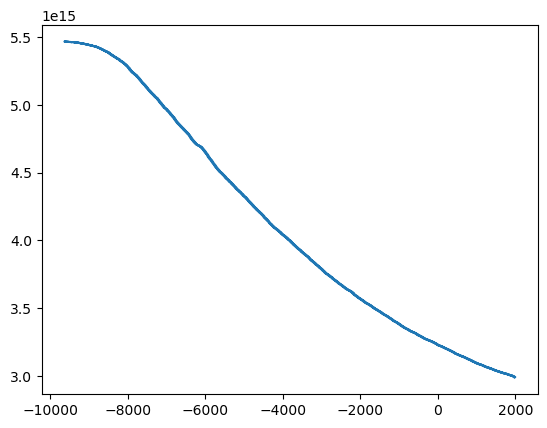

In [77]:
plt.plot(år_list, V_list_lang)

In [76]:
if isinstance(V_list_lang, list):
    print('liste')
else: 
    print('array')
print(V_list_lang)

array
[2.99000000e+15 2.99007345e+15 2.99007643e+15 ... 5.46522468e+15
 5.46522773e+15 5.46524150e+15]


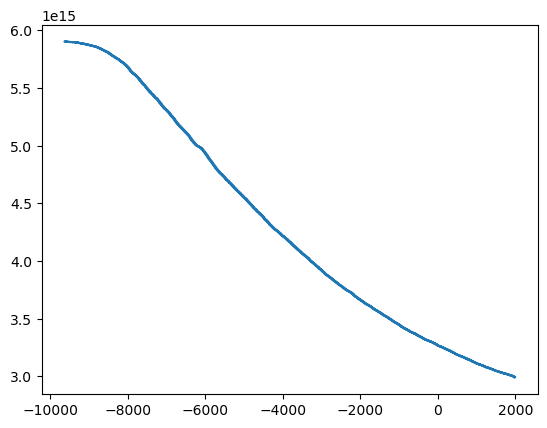

In [94]:
plt.plot(år_list, V_list_lang)

In [111]:
V = 2.99 * 10**15
H = 3 * 10**3            #m
R = (3/16*V/H)**(1/2)          #m
k = H/np.sqrt(R)  

H_list = np.sqrt(R_list_lang) * k
dH_list = H_list - H_list[0]

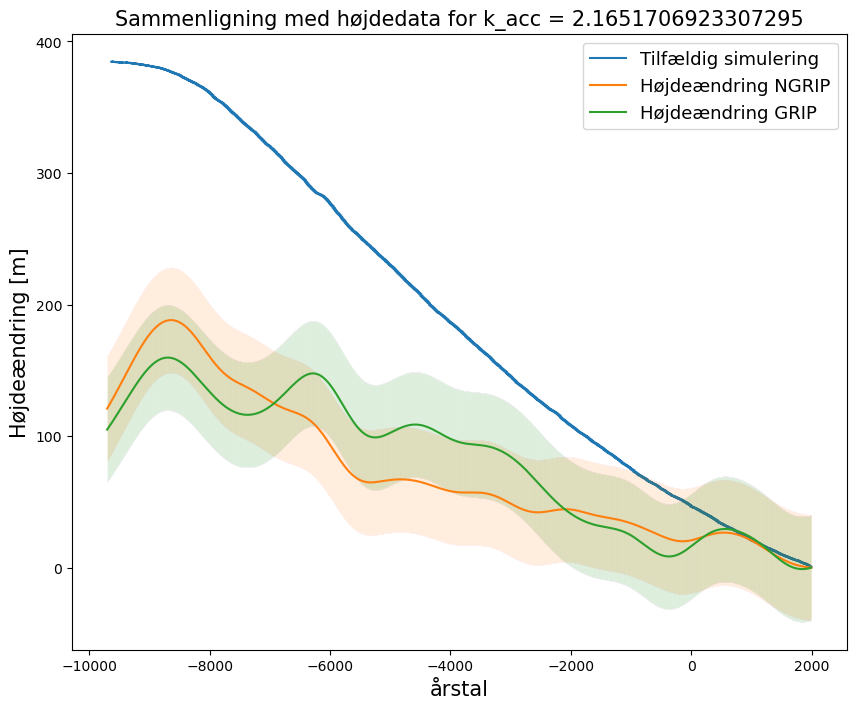

In [114]:
dhøjde_err_NGRIP = np.ones(len(NGRIP_delevation)) * 40
dhøjde_err_GRIP = np.ones(len(GRIP_delevation)) * 40

plt.figure(figsize = (10,8))
plt.title(f'Sammenligning med højdedata for k_acc = {k_acc_værdier[0]}', fontsize = 15)
plt.xlabel('årstal', fontsize = 15)
plt.ylabel('Højdeændring [m]', fontsize = 15)
plt.plot(år_list, dH_list, label = 'Tilfældig simulering')
markers, caps, bars = plt.errorbar(NGRIPår0, NGRIP_delevation, yerr = dhøjde_err_NGRIP, elinewidth=0.5, label = 'Højdeændring NGRIP')
[bar.set_alpha(0.01) for bar in bars]
marksers2, caps2, bars2 = plt.errorbar(GRIPår0, GRIP_delevation, yerr = dhøjde_err_GRIP,elinewidth=0.5, label = 'Højdeændring GRIP')
[bar.set_alpha(0.01) for bar in bars2]
plt.legend(fontsize = 13)
plt.savefig('Sammenligningmedhøjdedata-png')

#bars.set_alpha(0.05)

In [78]:
for i in range(1):
    V_list, R_list, år_list = langtidskørsel(k_acc_værdier[i], k_melt_list[i])
    np.savez_compressed(f'Voluminer_lang_test{i}.npz', V_list = V_list)
    np.savez_compressed(f'Radier_lang_test{i}.npz', R_list = R_list)
    np.savez_compressed(f'årstal_lang_test{i}.npz', år_list = år_list)

np.savez_compressed('k_værdier.npz', k_acc_værdier = k_acc_værdier)

In [80]:
år = np.load("årstal_lang_test0.npz")
#åår = år['V_kørsler']
voluminer = np.load('Voluminer_lang_test0.npz')
år = år['år_list']
voluminer = voluminer['V_list']

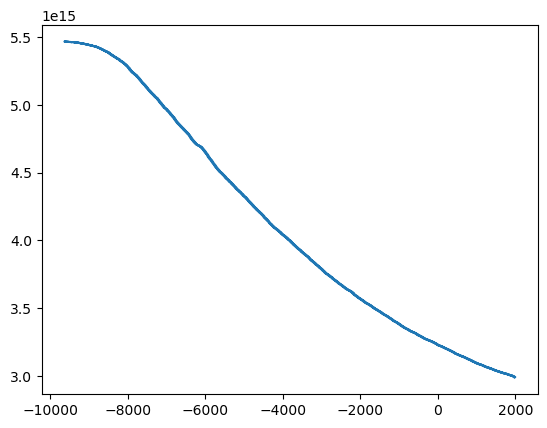

In [81]:
plt.plot(år, voluminer)

In [72]:
A = np.array([1,2,5])
B = np.array([2,3,4])

AA = [A,B]
print(AA)
print(A)

[array([1, 2, 5]), array([2, 3, 4])]
[1 2 5]


In [22]:
for i in range(2):      
    np.savez_compressed('test2.npz', AA[i])

In [23]:
data = np.load('test.npz')

print(data)

In [24]:
test2 = data['AA[0]']

KeyError: 'AA[0] is not a file in the archive'

In [3]:
import numpy as np

In [12]:
print(test2)

[1 2 5]


In [25]:
open('Gemme data.txt')

<_io.TextIOWrapper name='Gemme data.txt' mode='r' encoding='utf-8'>

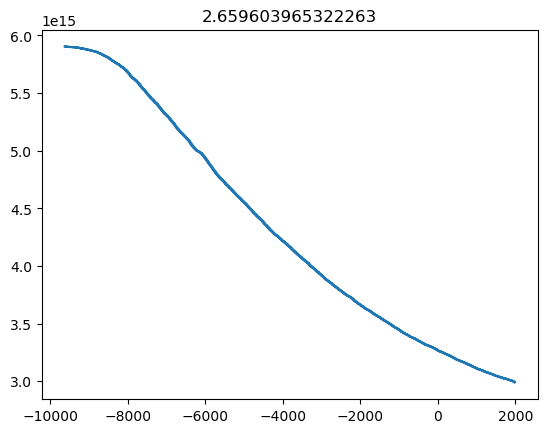

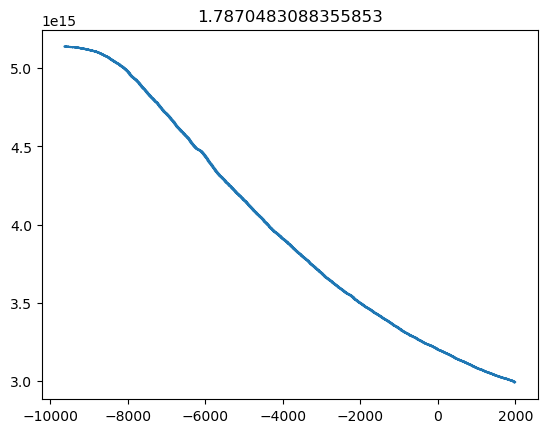

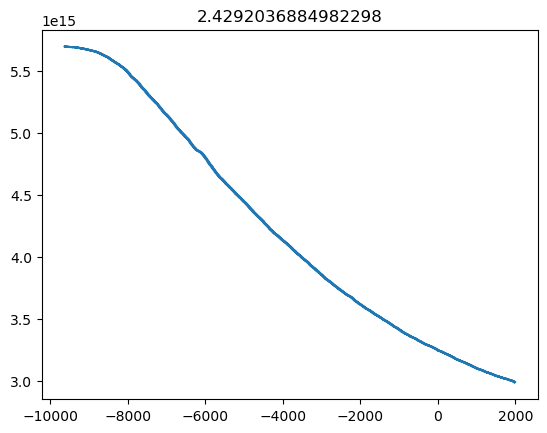

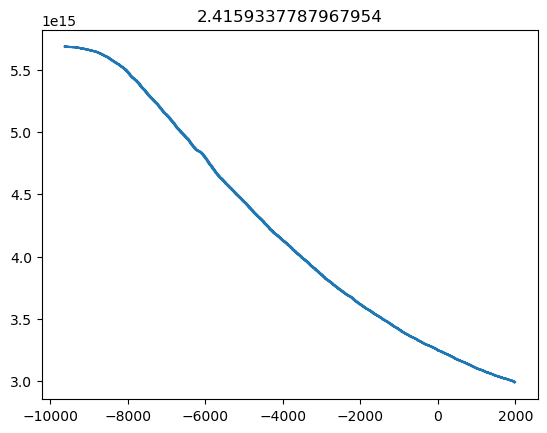

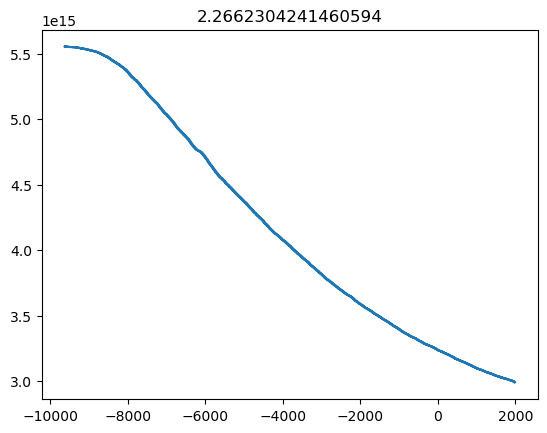

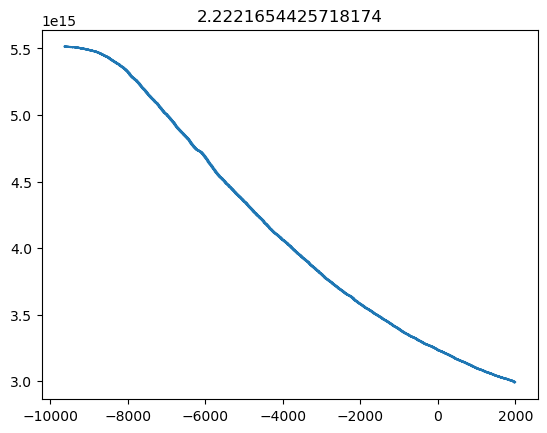

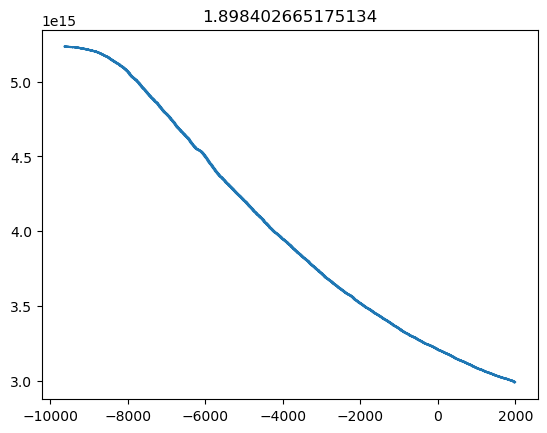

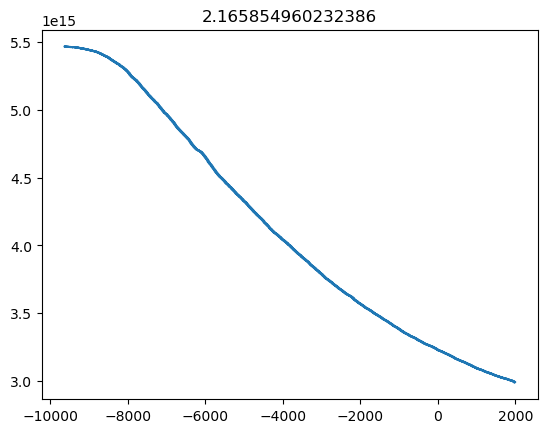

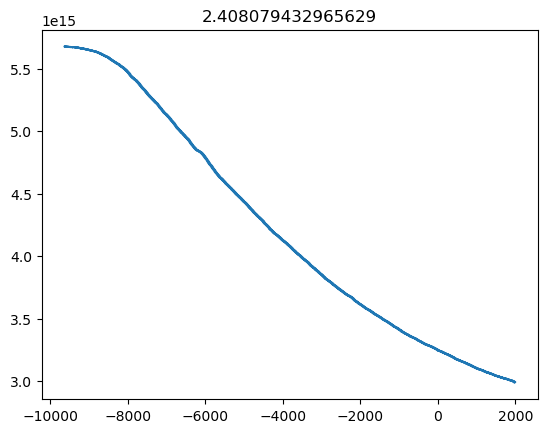

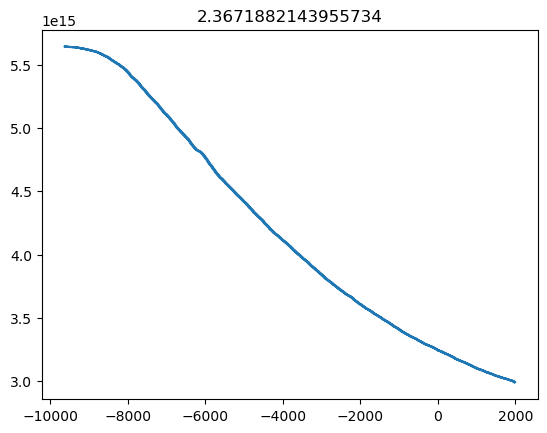

In [104]:
#for i in range(len(k_acc_værdier)):
#    plt.figure()
#    plt.title(k_acc_værdier[i])
#    plt.plot(år_kørsler[i], V_kørsler[i])

In [103]:
print(år_kørsler[0])

[1980.0, 1980.0684, 1980.1369, 1980.2053, 1980.2738, 1980.3422, 1980.4107, 1980.4791, 1980.5476, 1980.616, 1980.6845, 1980.7529, 1980.8214, 1980.8898, 1980.9582, 1981.0267, 1981.0951, 1981.1636, 1981.232, 1981.3005, 1981.3689, 1981.4374, 1981.5058, 1981.5743, 1981.6427, 1981.7112, 1981.7796, 1981.848, 1981.9165, 1981.9849, 1982.0534, 1982.1218, 1982.1903, 1982.2587, 1982.3272, 1982.3956, 1982.4641, 1982.5325, 1982.601, 1982.6694, 1982.7379, 1982.8063, 1982.8747, 1982.9432, 1983.0116, 1983.0801, 1983.1485, 1983.217, 1983.2854, 1983.3539, 1983.4223, 1983.4908, 1983.5592, 1983.6277, 1983.6961, 1983.7645, 1983.833, 1983.9014, 1983.9699, 1984.0383, 1984.1068, 1984.1752, 1984.2437, 1984.3121, 1984.3806, 1984.449, 1984.5175, 1984.5859, 1984.6543, 1984.7228, 1984.7912, 1984.8597, 1984.9281, 1984.9966, 1985.065, 1985.1335, 1985.2019, 1985.2704, 1985.3388, 1985.4073, 1985.4757, 1985.5441, 1985.6126, 1985.681, 1985.7495, 1985.8179, 1985.8864, 1985.9548, 1986.0233, 1986.0917, 1986.1602, 1986.2286,

In [ ]:
def hej(a,b):
    e = []
    d = np.linspace(0,1,10000)
    e.append(a+b*d)
    return e

In [ ]:
from tqdm import tqdm

n = 100

with tqdm(total = n) as pbar:
    for i in range(n):
        hej(1,2)
        pbar.update(1)


100%|██████████| 100/100 [00:00<00:00, 5647.07it/s]


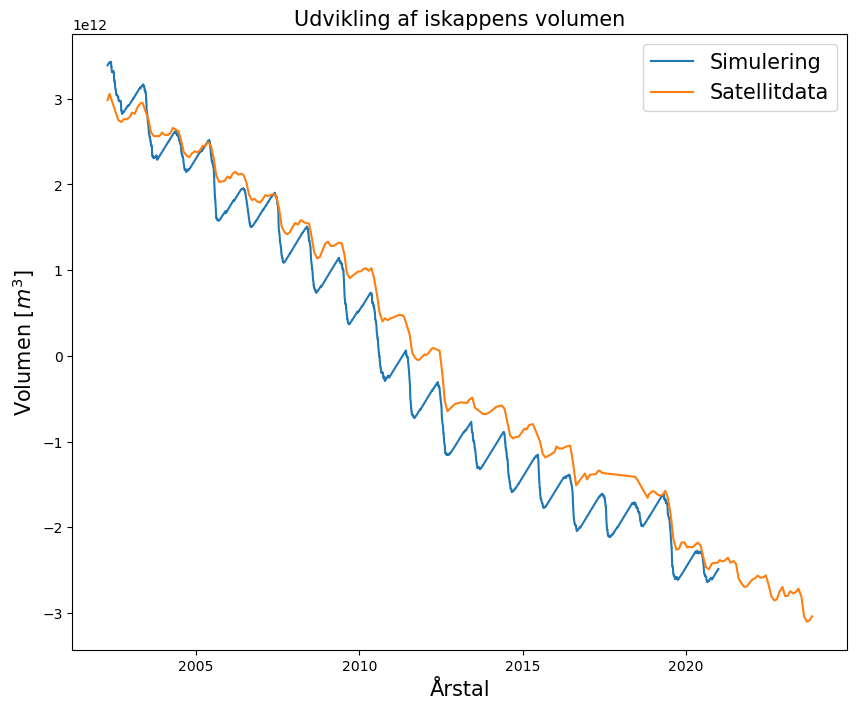

In [ ]:
# De globale konstanter defineres
V_0 = 2.85 * 10**15
V = 2.85 * 10**15   # startvolumen af iskappe
h = 3 * 10**3       # Starthøjde af iskappe
R = 500 * 10**3     # Startradius af iskappe
T_f = 0        
alfa = - 9.8 * 10**(-3)  # konstant hvormed temperatur stiger per meter
k = h/np.sqrt(R)   # formfaktor for iskappe. Antages global konstant
dt = 1/(365.25 * 4)  # Tidsskridt (her 1/2 døgn) - omregnet til år

# Tuningskonstanter
k_melt = par[0]
acc = akk_gns   # Nedbør pr år [m/år]. Antages konstant i perioden


# Der oprettes tomme lister til resultatet af simuleringen
V_list = []
V_melt_list = []
V_acc_list = []


for i in range(1, len(år) + 1):
    R = (3/16 * V/k)**(2/5)     # Ny radius af iskappe
    
    V_acc = k_acc * (acc * 8 * R**2) * dt  # Nedbøret dette tidsskridt
    
    if temp[-i] - T_f <= 0:
        V_melt = 0 
    elif temp[-i] - T_f > 0:
        V_melt = k_melt * 8/3 * R * (temp[-i] - T_f) * ((T_f - temp[-i])/(alfa * k))**2 * dt # ganger tidsskridt og M på
    V +=  - V_acc + V_melt
    
    V_list.append(V)
    V_melt_list.append(V_melt)
    V_acc_list.append(V_acc)

V_list.reverse()
dvol_sim = V_list - np.mean(V_list)
    
# Plot
    
plt.figure(figsize = (10,8))
plt.plot(år , dvol_sim, label = 'Simulering')
plt.xlabel('Årstal', fontsize = 15)
plt.ylabel(r'Volumen $[m^3]$', fontsize = 15)
plt.title('Udvikling af iskappens volumen', fontsize = 15)

plt.plot(år_sat, dvol_sat_korr, label = 'Satellitdata')
plt.legend(fontsize = 15)
plt.savefig('Tuning af smeltekonstant.png')


In [73]:
A = [1,2,3,4,5]
A = np.array(A)
A.index(2)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [75]:
np.where(A == 2)[0][0]

1